# 16 - Keras: Clasificación de tendencias politicas en tweets (Perceptrón Multicapa)

* En este notebook vamos a clasificar una serie de tweets etiquetados por un partido político (psoe, pp, vox, podemos y ciudadanos) que corresponden a la tendencia politica de la cuenta que publicó ese tweet,


* El ejercicio que vamos a realizar a continuación es muy similar al realizado en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb* y se pueden comparar los resultados que vamos a obtener con la Red Neuronal respecto a los obtenidos con los modelos generados por los algoritmos de clasificación vistos.


* Los pasos que vamos a dar son los siguientes:

    1. Cargar los datos
    2. Normalizar los tweets (igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb*)
    3. Particionado de datos (Train y Test)
    4. Bolsa de palabras y codificación del target
    5. Definición de la Red Neuronal
    6. Entrenamiento de la Red Neuronal
    7. Evaluación del modelo

<hr>


## Carga de Datos


* El fichero que contiene los tweets lo podemos leer como un '*csv*' con pandas pasandole como separador '***::::***'.


* Este fichero esta estructurado de la siguiente manera
    - **Cuenta**: Cuenta de twitter
    - **Partido**: Partido político al que pertenece (ciudadanos, podemos, pp, psoe)
    - **Timestamp**: Instante en el que se publicó el tweet
    - **Tweet**: Tweet.
    
    
* Leemos los datos y mostramos una muestra:

In [1]:
import pandas as pd

TWEETS_FILE = './data/tweets_politica_5P.csv'
df = pd.read_csv(TWEETS_FILE, sep='::::', engine='python')

# Eliminamos los tweets que tengan algún valor a nulo
df = df.dropna()
print('Número de Tweets Cargados: {num}'.format(num=df.shape[0]))

# Filtramos las cuentas de los partidos politicos y representantes
CUENTAS = ["PSOE", "sanchezcastejon",
           "populares", "pablocasado_",
           "vox_es", "Santi_ABASCAL", "Jorgebuxade",
           "PODEMOS", "PabloIglesias", "MiguelUrban", "pnique", "TeresaRodr_",
           "CiudadanosCs", "InesArrimadas"]
df = df[df['cuenta'].isin(CUENTAS)]

# Nos quedamos solo con el nombre del partido y el tweet
tweets = [tuple(x) for x in df[['tweet', 'partido']].values]

# Imprimimos el número de tweets a procesar
print('Número de Tweets a procesar: {num}'.format(num=df.shape[0]))
df.sample(10)

Número de Tweets Cargados: 65305
Número de Tweets a procesar: 24960


,cuenta,partido,timestamp,tweet
55737,Jorgebuxade,vox,1.583825e+09,🔴🔴El sectarismo del consenso progre y su nece...
19357,PSOE,psoe,1.570725e+09,🌹 @sanchezcastejon: Se necesitan infraestructu...
18191,populares,pp,1.570613e+09,▶ @pablocasado_ se compromete en la Comunidad ...
19338,pablocasado_,pp,1.570713e+09,La economía no va bien y el Gobierno presenta ...
15460,Jorgebuxade,vox,1.569112e+09,"@hermanntertsch , vicepresidente de @ecrgroup,..."
37728,vox_es,vox,1.578145e+09,"🏛️ @Santi_ABASCAL ""Sánchez quiere disolver la ..."
7803,CiudadanosCs,ciudadanos,1.563377e+09,😠 Sánchez trata de esconder el bloqueo de las ...
18224,populares,pp,1.570515e+09,▶ “El PSOE tiene que hacerse una enmienda a sí...
52850,Santi_ABASCAL,vox,1.583065e+09,"Este insulto de autoridades francesas, recibie..."
59260,PODEMOS,podemos,1.584620e+09,"🎥""El Ministerio de Defensa y el Ministerio de ..."


* Tweets publicados por partido político

In [2]:
df.groupby('partido')['tweet'].count().reset_index().sort_values(by='tweet', ascending=False)

,partido,tweet
3,psoe,6123
1,podemos,5055
2,pp,4837
4,vox,4722
0,ciudadanos,4223


<hr>


## Normalización

* Utilizamos ***spaCy*** para la tokenización y normalización.


* Tras realizar un análisis del contenido de los tweets pasamos a realizar las siguientes acciones para ***normalizar*** los tweets:
    1. Pasamos las frases a minúsculas.
    2. Sustituimos los puntos por espacios ya que hay muchas palabras unidas por un punto
    3. Quitamos la almuhadilla de los hashtags para considerarlos como palabras.
    4. Eliminamos los signos de puntuación.
    5. Eliminamos las palabras con menos de 3 caracteres.
    6. Eliminamos las Stop-Words.
    7. Eliminamos los enlaces(http) y las menciones (@)
    8. Pasamos la palabra a su lema


* Todos estos pasos los vamos a realizar en una misma función.


* ***NOTA***: Se pueden realizar más acciones de normalización que las realizadas, como tratamiento de emoticonos, tratamiento especial de referencia a cuentas, hashtags, etc. Al tratarse de un ejemplo didáctica se ha realizado una normalización '*sencilla*'.

In [3]:
import numpy as np
import spacy
nlp = spacy.load('es_core_news_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[0] for doc in tweets]
y = np.array([doc[1] for doc in tweets])

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(sentenses):
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        sentense = nlp(sentense.lower().replace('.', ' ').replace('#', ' ').strip())
        # Puntos 4,5,6,7 y 8
        sentenses[index] = ([word.lemma_ for word in sentense if (not word.is_punct)
                             and (len(word.text) > 2) and (not word.is_stop)
                             and (not word.text.startswith('@'))
                             and (not word.text.startswith('http'))
                             and (not ':' in word.text)])
    return sentenses

# Normalizamos las frases
X_norm = normalize(X)

<hr>


## Particionado de Datos (Train y Test)

* Vamos a particionar los datos en conjunto de Train y Test.


* Para este ejemplo nos vamos a quedar con:
    - 90% de datos de entrenamiento
    - 10% de datos de test

In [4]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.1, random_state=0)

print('Número de Tweets para el entrenamiento: {num}'.format(num=len(X_train)))
print('Número de Tweets para el test: {num}'.format(num=len(X_test)))

Número de Tweets para el entrenamiento: 22464
Número de Tweets para el test: 2496


<hr>


# Bolsa de palabras y codificación del target


* Al igual que en el notebook *13_PoC_Tendencias_Politicas_Twitter_Generacion_Exportacion_Modelos.ipynb* vamos a trabajar con las 1000 palabras de mayor frecuencia del corpus.


* Realizaremos una codificación del nombre del partido político utilizando la clase "LabelEncoder()" de scikit.

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils


# Bolsa de Palabras
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_matrix = tokenizer.texts_to_matrix(X_train, mode='count')
X_matrix_test = tokenizer.texts_to_matrix(X_test, mode='count')

# Codificación del Target
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

Using TensorFlow backend.


<hr>


# Definición de la Red Neuronal



* Para clasificar los tweets en alguna de las 4 tendencias políticas definidas, vamos a crear una red con la siguiente arquitectura:
<span></span><br><br>
    - ***Capa 1***: Capa de entrada con 1000 Neuronas (una por palabra del corpus)
<span></span><br><br>
    - ***Capa 2***: 20 Neuronas con una función de activación 'relu'
<span></span><br><br>
    - ***Capa 3***: 10 Neuronas con una función de activación 'relu'
<span></span><br><br>
    - ***Capa 4***: Capa de salida con 5 neurona (una por tendencia política) y una función de activación 'softmax' para que nos "normalice la salida"
    
    
* Para las capas 2 y 3 vamos a poner un dropout del 20% para que nuestra red no se sobreajuste y generalize mejor


* Por último vamos a compilar la red:
<span></span><br><br>
    - ***Función de perdida: 'categorical_crossentropy'*** (Funciones de Perdida: https://keras.io/losses/)
<span></span><br><br>
    - ***Optimizador: 'adam'*** (Optimizadores: https://keras.io/optimizers/)
<span></span><br><br>
    - Metricas: en cada epoch pediremos que nos muestre el accuracy.

In [6]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics

np.random.seed(9)
model = Sequential()
model.add(Dense(20, activation='relu', input_dim=max_words))
model.add(Dropout(0.2))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

* Una vez creada la red mostramos su arquitectura:
    - 1000 Neuronas de entrada
    - Capa 2: 20 Neuronas
    - Conexiones "capa de entrada -> Capa 2" = (1000*20) + 20 = 20020 Conexiones
    - Capa 3: 10 Neuronas
    - Conexiones "Capa 2 -> Capa 3" = (20*10) + 10 = 210 Conexiones
    - Capa de salida: 4 Neuronas
    - Conexiones "Capa 3 -> Capa de salida" = (10*5) + 5 = 55 Conexiones

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                20020     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
Total params: 20,285
Trainable params: 20,285
Non-trainable params: 0
_________________________________________________________________


<hr>


# Entrenamiento de la Red Neuronal


* Como lo que estamos haciendo es un ejemplo didáctico vamos a poner los siguientes valores:
<span></span><br><br>
    - *batch_size = 64* : Cada 64 tweets se calculan los nuevos pesos de la red
<span></span><br><br>
    - *epochs = 200*
<span></span><br><br>
    - *validation_split = 0.2* 


In [8]:
history = model.fit(X_matrix, y_train, batch_size=64, epochs=200, verbose=2, validation_split=0.2)

Train on 17971 samples, validate on 4493 samples
Epoch 1/200
 - 1s - loss: 1.4302 - accuracy: 0.3749 - val_loss: 1.1477 - val_accuracy: 0.5965
Epoch 2/200
 - 1s - loss: 1.0824 - accuracy: 0.5830 - val_loss: 0.9116 - val_accuracy: 0.6777
Epoch 3/200
 - 1s - loss: 0.9374 - accuracy: 0.6429 - val_loss: 0.8581 - val_accuracy: 0.6922
Epoch 4/200
 - 1s - loss: 0.8772 - accuracy: 0.6723 - val_loss: 0.8326 - val_accuracy: 0.6955
Epoch 5/200
 - 1s - loss: 0.8386 - accuracy: 0.6887 - val_loss: 0.8245 - val_accuracy: 0.6944
Epoch 6/200
 - 1s - loss: 0.8098 - accuracy: 0.6969 - val_loss: 0.8192 - val_accuracy: 0.6924
Epoch 7/200
 - 1s - loss: 0.7739 - accuracy: 0.7150 - val_loss: 0.8266 - val_accuracy: 0.6949
Epoch 8/200
 - 1s - loss: 0.7590 - accuracy: 0.7155 - val_loss: 0.8227 - val_accuracy: 0.6920
Epoch 9/200
 - 1s - loss: 0.7372 - accuracy: 0.7272 - val_loss: 0.8254 - val_accuracy: 0.6944
Epoch 10/200
 - 1s - loss: 0.7134 - accuracy: 0.7349 - val_loss: 0.8294 - val_accuracy: 0.6902
Epoch 11/2

Epoch 87/200
 - 1s - loss: 0.3943 - accuracy: 0.8530 - val_loss: 1.7572 - val_accuracy: 0.6548
Epoch 88/200
 - 1s - loss: 0.3950 - accuracy: 0.8543 - val_loss: 1.7795 - val_accuracy: 0.6521
Epoch 89/200
 - 1s - loss: 0.3883 - accuracy: 0.8559 - val_loss: 1.8266 - val_accuracy: 0.6503
Epoch 90/200
 - 1s - loss: 0.3924 - accuracy: 0.8560 - val_loss: 1.8037 - val_accuracy: 0.6532
Epoch 91/200
 - 1s - loss: 0.3772 - accuracy: 0.8632 - val_loss: 1.8213 - val_accuracy: 0.6548
Epoch 92/200
 - 1s - loss: 0.3892 - accuracy: 0.8550 - val_loss: 1.8207 - val_accuracy: 0.6544
Epoch 93/200
 - 1s - loss: 0.3838 - accuracy: 0.8579 - val_loss: 1.8657 - val_accuracy: 0.6552
Epoch 94/200
 - 1s - loss: 0.3780 - accuracy: 0.8591 - val_loss: 1.8753 - val_accuracy: 0.6555
Epoch 95/200
 - 1s - loss: 0.3736 - accuracy: 0.8606 - val_loss: 1.8787 - val_accuracy: 0.6530
Epoch 96/200
 - 1s - loss: 0.3820 - accuracy: 0.8595 - val_loss: 1.8698 - val_accuracy: 0.6568
Epoch 97/200
 - 1s - loss: 0.3809 - accuracy: 0.86

Epoch 173/200
 - 1s - loss: 0.3261 - accuracy: 0.8795 - val_loss: 3.1277 - val_accuracy: 0.6528
Epoch 174/200
 - 1s - loss: 0.3265 - accuracy: 0.8757 - val_loss: 3.1602 - val_accuracy: 0.6557
Epoch 175/200
 - 1s - loss: 0.3382 - accuracy: 0.8716 - val_loss: 3.1729 - val_accuracy: 0.6535
Epoch 176/200
 - 1s - loss: 0.3287 - accuracy: 0.8750 - val_loss: 3.1975 - val_accuracy: 0.6530
Epoch 177/200
 - 1s - loss: 0.3243 - accuracy: 0.8786 - val_loss: 3.1947 - val_accuracy: 0.6526
Epoch 178/200
 - 1s - loss: 0.3338 - accuracy: 0.8760 - val_loss: 3.1937 - val_accuracy: 0.6544
Epoch 179/200
 - 1s - loss: 0.3206 - accuracy: 0.8796 - val_loss: 3.2017 - val_accuracy: 0.6515
Epoch 180/200
 - 1s - loss: 0.3265 - accuracy: 0.8769 - val_loss: 3.2765 - val_accuracy: 0.6510
Epoch 181/200
 - 1s - loss: 0.3144 - accuracy: 0.8820 - val_loss: 3.2283 - val_accuracy: 0.6508
Epoch 182/200
 - 1s - loss: 0.3214 - accuracy: 0.8804 - val_loss: 3.2130 - val_accuracy: 0.6490
Epoch 183/200
 - 1s - loss: 0.3263 - acc

* Pintamos como evoluciona la función de perdida y el Accuracy por epoch tanto en entrenamiento como en test.

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Pintamos las métricas por epoch
def plot_metric(history, name, remove_first=0):
    metric_train = np.array(history.history[name])[remove_first:]
    metric_test = np.array(history.history['val_{}'.format(name)])[remove_first:]
    acum_avg_metric_train = (np.cumsum(metric_train) / (np.arange(metric_train.shape[-1]) + 1))[remove_first:]
    acum_avg_metric_test = (np.cumsum(metric_test) / (np.arange(metric_test.shape[-1]) + 1))[remove_first:]
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title('{} - Epochs'.format(name))
    plt.plot(metric_train, label='{} Train'.format(name))
    plt.plot(metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.subplot(1, 2, 2)
    plt.title('AVG ACCUMULATIVE {} - Epochs'.format(name))
    plt.plot(acum_avg_metric_train, label='{} Train'.format(name))
    plt.plot(acum_avg_metric_test, label='{} Test'.format(name))
    plt.grid()
    plt.legend(loc='upper center')
    plt.show()

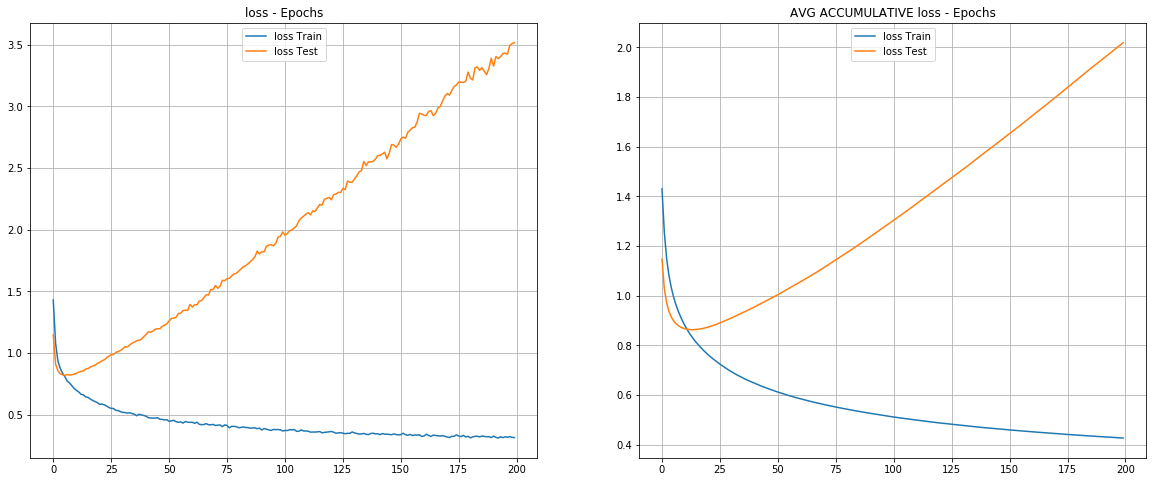

In [10]:
# Función de perdida
plot_metric(history=history, name='loss')

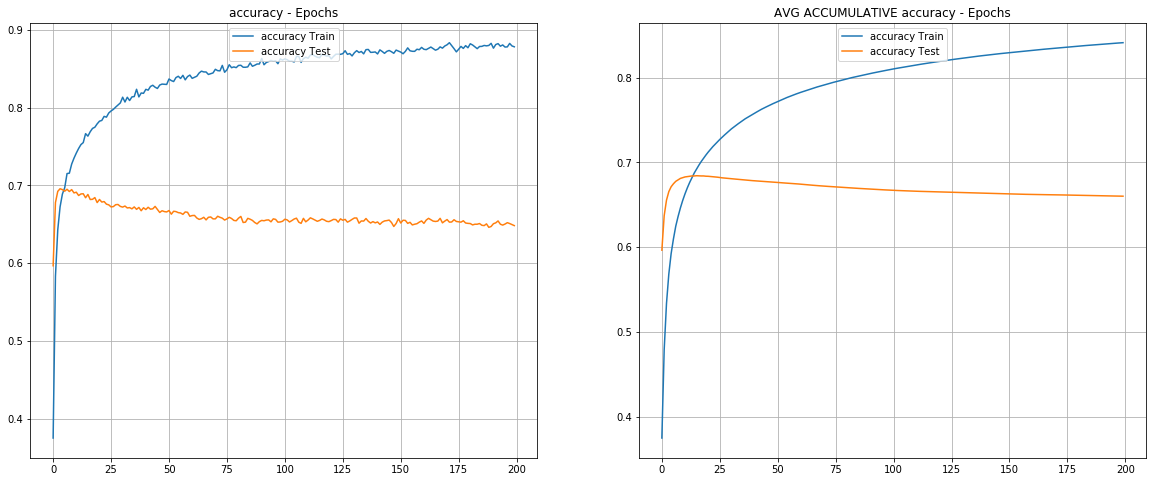

In [11]:
# Accuracy
plot_metric(history=history, name='accuracy')

<hr>


# Evaluamos el modelo

* Pasamos a evaluar el modelo, calculando las siguientes métricas de evaluación:

    1. **Accuracy**
    2. **Precision**
    3. **Recall**
    4. **F1**

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

y_true = encoder.inverse_transform(y_test.reshape(-1))
y_pred = model.predict_classes(X_matrix_test)
y_pred = encoder.inverse_transform(y_pred.reshape(-1))

print('Accuracy: {acc:0.4f}'.format(acc=accuracy_score(y_true=y_true, y_pred=y_pred)))
print('F1: {f1:0.4f}'.format(f1=f1_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Precision: {pre:0.4f}'.format(pre=precision_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print('Recall: {rec:0.4f}'.format(rec=recall_score(y_true=y_true, y_pred=y_pred, average='weighted')))
print(classification_report(y_true=y_true, y_pred=y_pred))
labels = ['psoe', 'pp', 'vox', 'podemos', 'ciudadanos']
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)

Accuracy: 0.6486
F1: 0.6464
Precision: 0.6479
Recall: 0.6486
              precision    recall  f1-score   support

  ciudadanos       0.71      0.64      0.67       439
     podemos       0.58      0.56      0.57       508
          pp       0.65      0.58      0.61       492
        psoe       0.68      0.80      0.74       588
         vox       0.62      0.62      0.62       469

    accuracy                           0.65      2496
   macro avg       0.65      0.64      0.64      2496
weighted avg       0.65      0.65      0.65      2496



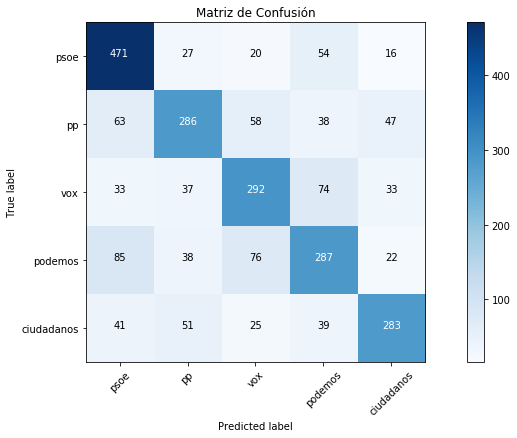

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Pintamos la matriz de confusión
plt.figure(figsize=(12, 6))
plot_confusion_matrix(confusion_matrix, classes=labels, title='Matriz de Confusión')
plt.show()